In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

#from evaluation_functions import *
from importlib import reload
from functions_ import *
from plotting import *

In [22]:
## reload the evaluation functions
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *



In [3]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = "" #"ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = "" #"GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_fwd": "AAGG",
            "BC1_rev": "ATCA",
            "BC2_fwd": "AGTC",
            "BC2_rev": "GCCG",
            "BC3_fwd": "AGGA",
            "BC3_rev": "AATT",
            "BC4_fwd": "GCGA",
            "BC4_rev": "TGGT",
            "BC5_fwd": "CCAT",
            "BC5_rev": "GACC",
            "BC6_fwd": "CTAG",
            "BC6_rev": "CCAG",
            }
            

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd = "GGCGCAACTATCGGTATCAAGC",
            S1_rev = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev = "ACATGCTGCGCCACGCTC",
            S4_fwd = "GATAACCGCGTGCGCGAA",
            S4_rev = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd": 2,
                     "S1_rev": 1, 
                     "S2_fwd": 2,
                     "S2_rev": 1,
                     "S3_fwd": 1,
                     "S3_rev": 2,
                     "S4_fwd": 0,
                     "S4_rev": 3} ##?

for key in Primer_out_of_triplets.keys():
    Primer_out_of_triplets[key] =  Primer_out_of_triplets[key] +3

In [ ]:
Primer_out_of_triplets

In [32]:
## add numbers of positions to the sequence
R5_Pool_AA = translate_dna2aa(R5_Pool_seq[5:])
AraC_AA_start_pos = 37
LOV2_AA_start_pos = 210
LOV2_AA_end_pos = 351# len 145
AraC_end_pos = 477 # len 124

AA_berfore_AraC_start = [R5_Pool_AA[i] for i in range(AraC_AA_start_pos)]
AA_AraC_part1 = [R5_Pool_AA[i]+str(i-AraC_AA_start_pos) for i in range(AraC_AA_start_pos,LOV2_AA_start_pos-2)]
AA_linker1 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_start_pos+2) for i in range(LOV2_AA_start_pos-2,LOV2_AA_start_pos)]
AA_Lov2 = [R5_Pool_AA[i]+str(404+i-LOV2_AA_start_pos) for i in range(LOV2_AA_start_pos,LOV2_AA_end_pos)]
AA_linker2 = [R5_Pool_AA[i]+str(i+1-LOV2_AA_end_pos+2) for i in range(LOV2_AA_end_pos,LOV2_AA_end_pos+2)]
AA_AraC_part2 = [R5_Pool_AA[i]+str((LOV2_AA_start_pos-2-AraC_AA_start_pos)+i-(LOV2_AA_end_pos+2)) for i in range(LOV2_AA_end_pos+2,AraC_end_pos )]
AA_after_AraC = [R5_Pool_AA[i] for i in range(AraC_end_pos,len(R5_Pool_AA))]

R5_Pool_AA_annot = AA_berfore_AraC_start + AA_AraC_part1 + AA_linker1 + AA_Lov2 + AA_linker2 + AA_AraC_part2 + AA_after_AraC

# AraC analysis

In [ ]:
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
variant1 ="MutS2S3_2"#"MutS2S3_2"#"S2S3alt3cyclesmut"
variant1_used_BCs = ["BC1", "BC2", "BC3"] 


variant2 ="NegPosS2S3_2" #"NegPosS2S3_2"#"S2S3alt3cyclesNegPos"
variant2_used_BCs = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]

### for repeated seq of S2, S3, different primers were used:
Primer_seq["S2_fwd"] = "GCATTTTAGCGATCTGTTTGGCC"
Primer_seq["S3_fwd"] = "TTCTGGAATTTATTTCACTTGCAGCC"

# Primer_out_of_triplets["S2_fwd"] = 1
# Primer_out_of_triplets["S3_fwd"] = 0

ref_gene = R5_Pool_seq

catch_left = catch_left
catch_right = catch_right

Sections = ["S2", "S3"]

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections =Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 15, a_ids=a_ids, b_ids=b_ids, filter_for_read_len=False, read_len_treshold= None)#(150, 150)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 15, a_ids=a_ids, b_ids=b_ids,  filter_for_read_len=False, read_len_treshold= None) 

all_reads = {**{variant1+"_"+key : value for key, value in Mutagenesis_reads.items()},**{variant2+"_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},**{variant2+"_"+key : value for key, value in NegPos_ids.items()}}

samples = ['S2S3alt3cyclesmut_BC1',
 'S2S3alt3cyclesNegPos_BC1',
 'S2S3alt3cyclesNegPos_BC2',
 'S2S3alt3cyclesmut_BC2',
 'S2S3alt3cyclesNegPos_BC3',
 'S2S3alt3cyclesNegPos_BC4',
 'S2S3alt3cyclesmut_BC3',
 'S2S3alt3cyclesNegPos_BC5',
 'S2S3alt3cyclesNegPos_BC6'] # use only R1 names 

samples = ['MutS2S3_2_BC1',
 'NegPosS2S3_2_BC1',
 'NegPosS2S3_2_BC2',
 'MutS2S3_2_BC2',
 'NegPosS2S3_2_BC3',
 'NegPosS2S3_2_BC4',
 'MutS2S3_2_BC3',
 'NegPosS2S3_2_BC5',
 'NegPosS2S3_2_BC6']

plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]

FigFolder = None


In [ ]:
### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',]
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']


variant1 = "Cycle2Mutagenesis"
variant1_used_BCs = ["BC1"] #["BC1", "BC2"]

variant2 = "Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2"]#["BC1", "BC2", "BC3", "BC4"]

variant3 = "Mutagenesis"
variant3_used_BCs = ["BC1", "BC2"]

variant4 = "NegPosSelection"
variant4_used_BCs = ["BC1", "BC2", "BC3", "BC4"]

catch_left = catch_left
catch_right = catch_right

## variant1
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Cycle2Mutagenesis_reads, Cycle2Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= None)#(150, 150)


## variant2
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Cycle2NegPosSelection_reads, Cycle2NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None)


## variant3
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant3, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant3_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None)#(150, 150)


## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant4, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant4_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= None)


Mut_names = {"BC1": "Mut1", 
             "BC2" : "Mut3"}

NegPos_names = {"BC1": "Neg1",
                "BC2": "Pos1", 
                "BC3": "Neg3", 
                "BC4": "Pos3"}

Mut_names_2 = {"BC1": "Mut2"}
NegPos_names_2 = {"BC1": "Neg2",
                "BC2": "Pos2"}

all_reads = {**{Mut_names_2[key[:3]]+"_"+key[4:] : value for key, value in Cycle2Mutagenesis_reads.items()},
            **{NegPos_names_2[key[:3]]+"_"+key[4:] : value for key, value in Cycle2NegPosSelection_reads.items()}, 
            **{Mut_names[key[:3]]+"_"+key[4:] : value for key, value in Mutagenesis_reads.items()},
            **{NegPos_names[key[:3]]+"_"+key[4:] : value for key, value in NegPosSelection_reads.items()}}


# all_reads = {**{variant1+"_"+key[4:] : value for key, value in Cycle2Mutagenesis_reads.items()},
#             **{variant2+"_"+key[4:]  : value for key, value in Cycle2NegPosSelection_reads.items()}, 
#             **{variant3+"_"+key[4:]  : value for key, value in Mutagenesis_reads.items()},
#             **{variant4+"_"+key[4:]  : value for key, value in NegPosSelection_reads.items()}}

# all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},
#            **{variant2+"_"+key : value for key, value in NegPos_ids.items()}}

# samples = ["Mutagenesis_BC1", "NegPosSelection_BC1", "NegPosSelection_BC2", "Cycle2Mutagenesis_BC1", "Cycle2NegPos_BC1", "Cycle2NegPos_BC2","Mutagenesis_BC2", "NegPosSelection_BC3", "NegPosSelection_BC4"]

# samples = ["Mutagenesis", "NegPosSelection", "NegPosSelection", "Cycle2Mutagenesis", "Cycle2NegPos", "Cycle2NegPos","Mutagenesis", "NegPosSelection", "NegPosSelection"]


samples = ["Mut1", "Neg1", "Pos1", "Mut2", "Neg2", "Pos2", "Mut3", "Neg3", "Pos3"]

plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]

Sections = ["S1", "S2", "S3", "S4"]


In [23]:
############### add repeated S2 S3 seq data ####################

Primer_seq = dict(
            S1_fwd = "GGCGCAACTATCGGTATCAAGC",
            S1_rev = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev = "ACATGCTGCGCCACGCTC",
            S4_fwd = "GATAACCGCGTGCGCGAA",
            S4_rev = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

Primer_out_of_triplets ={'S1_fwd': 5,
                        'S1_rev': 4,
                        'S2_fwd': 5,
                        'S2_rev': 4,
                        'S3_fwd': 4,
                        'S3_rev': 5,
                        'S4_fwd': 3,
                        'S4_rev': 6}



start_S2_rep = "GCATTTTAGCGATCTGTTTGGCC"
start_S3_rep = "TTCTGGAATTTATTTCACTTGCAGCC"

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']


variant1 = "Cycle2Mutagenesis"
variant1_used_BCs = ["BC1"] #["BC1", "BC2"]

variant2 = "Cycle2NegPos"
variant2_used_BCs = ["BC1", "BC2"]#["BC1", "BC2", "BC3", "BC4"]

variant3 = "Mutagenesis"
variant3_used_BCs = ["BC1", "BC2"]

variant4 = "NegPosSelection"
variant4_used_BCs = ["BC1", "BC2", "BC3", "BC4"]

catch_left = catch_left
catch_right = catch_right

## variant1
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Cycle2Mutagenesis_reads, Cycle2Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold=None, Primer_out_of_triplets= Primer_out_of_triplets)#(150, 150)


## variant2
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Cycle2NegPosSelection_reads, Cycle2NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None, Primer_out_of_triplets= Primer_out_of_triplets)


## variant3
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant3, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant3_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,read_len_treshold= None, Primer_out_of_triplets= Primer_out_of_triplets)#(150, 150)


## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant4, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant4_used_BCs, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= None, Primer_out_of_triplets= Primer_out_of_triplets)


### names 

Mut_names = {"BC1": "Mut1", 
             "BC2" : "Mut3"}

NegPos_names = {"BC1": "Neg1",
                "BC2": "Pos1", 
                "BC3": "Neg3", 
                "BC4": "Pos3"}

Mut_names_2 = {"BC1": "Mut2"}
NegPos_names_2 = {"BC1": "Neg2",
                "BC2": "Pos2"}

all_reads = {**{Mut_names_2[key[:3]]+"_"+key[4:] : value for key, value in Cycle2Mutagenesis_reads.items()},
            **{NegPos_names_2[key[:3]]+"_"+key[4:] : value for key, value in Cycle2NegPosSelection_reads.items()}, 
            **{Mut_names[key[:3]]+"_"+key[4:] : value for key, value in Mutagenesis_reads.items()},
            **{NegPos_names[key[:3]]+"_"+key[4:] : value for key, value in NegPosSelection_reads.items()}}

# all_ids = {**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},
#            **{variant2+"_"+key : value for key, value in NegPos_ids.items()}}


### cut reads at stat pos of repeated sequencing exp 
for key, reads in all_reads.items(): 
    if "S2_R1" in key: 
        all_reads[key] = [a[:144] if len(a)>=144 else a for a in reads] ### len of the read up to start of the repeated seq (152) - Primer_out_of_triplets["S2_fwd"] = 5 
    elif "S2_R2" in key: 
        all_reads[key] = [""]*len(reads)
    elif "S3_R1" in key: 
        all_reads[key] = [b[:180] if len(b)>= 180 else b for b in reads] ### len of the read up to start of the repeated seq (187) - Primer_out_of_triplets["S3_fwd"] = 4
    elif "S3_R2" in key: 
        all_reads[key] = [""]*len(reads)

## change "Primer" seq (represents end of amplicon) according to repeated seq exp (i.e. this is now the seq right before the primer of the rep sequencing exp (include also 9 nts from the primer to ensure a small overlap)) (not necessary since we cut all reads at the start pos of the repeated seq exp, also we exclude rev reads by "")
        
Primer_seq["S2_rev"] = dna_rev_comp("gaagcgcatcagccgcattttagc".upper())
Primer_seq["S3_rev"] = dna_rev_comp("cgaagagcggaaaaaaattctggaat".upper()) 

Primer_out_of_triplets["S2_rev"] = 0+3
Primer_out_of_triplets["S3_rev"] = 0+3

############### add repeated S2 S3 seq data ####################

remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-']

variant1 ="MutS2S3_2"#"MutS2S3_2"#"S2S3alt3cyclesmut"
variant1_used_BCs = ["BC1", "BC2", "BC3"] 

variant2 ="NegPosS2S3_2" #"NegPosS2S3_2"#"S2S3alt3cyclesNegPos"
variant2_used_BCs = ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"]

### for repeated seq of S2, S3, different primers were used:

Primer_seq["S2.2_fwd"] = "GCATTTTAGCGATCTGTTTGGCC"
Primer_seq["S3.2_fwd"] = "TTCTGGAATTTATTTCACTTGCAGCC"

Primer_seq["S2.2_rev"] = "TAGCACGGTCAGTCTCTGGC" # these are in principle the same primers as before, but we have overwritten them above (since the end of S2,S3 is now changed according to the start pos of repeated seq (see above) )
Primer_seq["S3.2_rev"] = "ACATGCTGCGCCACGCTC"

Primer_out_of_triplets["S2.2_fwd"] = 1+3
Primer_out_of_triplets["S3.2_fwd"] = 0+3

Primer_out_of_triplets["S2.2_rev"] = 1+3
Primer_out_of_triplets["S3.2_rev"] = 2+3

Sections = ["S2.2", "S3.2"]

a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = variant1, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant1_used_BCs, Sections =Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids, filter_for_read_len=False, read_len_treshold=None, Primer_out_of_triplets= Primer_out_of_triplets)#(150, 150)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant2, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = variant2_used_BCs, Sections = Sections, max_mismatch_primerseq = 3, filter_for_n_mut = True, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  filter_for_read_len=False, read_len_treshold= None, Primer_out_of_triplets= Primer_out_of_triplets) 


Mutagenesis_names = {"BC1": "Mut1", 
                     "BC2": "Mut2",
                     "BC3": "Mut3"}

NegPos_names = {"BC1": "Neg1", 
                "BC2": "Pos1", 
                "BC3": "Neg2", 
                "BC4": "Pos2", 
                "BC5": "Neg3", 
                "BC6": "Pos3"
                  }
           
all_reads = {**all_reads, **{**{Mutagenesis_names[key[:3]]+"_"+key[4:] : value for key, value in Mutagenesis_reads.items()},**{NegPos_names[key[:3]]+"_"+key[4:] : value for key, value in NegPosSelection_reads.items()}}}

# all_ids = {**all_ids, **{**{variant1+"_"+key : value for key, value in Mut_ids_Dict.items()},**{variant2+"_"+key : value for key, value in NegPos_ids.items()}}}

samples = ["Mut1", "Neg1", "Pos1", "Mut2", "Neg2", "Pos2", "Mut3", "Neg3", "Pos3"]

plt_titles =["Mutagenesis cycle 1", "Negative selection cycle 1", "Positive selection cycle 1", "Mutagenesis cycle 2", "Negative selection cycle 2", "Positive selection cycle 2","Mutagenesis cycle 3", "Negative selection cycle 3", "Positive selection cycle 3"]

Sections = ["S1", "S2","S2.2", "S3", "S3.2", "S4"]

FigFolder = None


total reads 68823
BC1 S1 20365 reads
total forward reads before filtering 16608
total reverse reads before filtering 11948
total forward reads after filtering 11769
total reverse reads after filtering 10491
BC1 S2 25531 reads
total forward reads before filtering 21681
total reverse reads before filtering 16213
total forward reads after filtering 13775
total reverse reads after filtering 13478
BC1 S3 24832 reads
total forward reads before filtering 21245
total reverse reads before filtering 15522
total forward reads after filtering 15823
total reverse reads after filtering 12638
BC1 S4 28318 reads
total forward reads before filtering 24964
total reverse reads before filtering 18482
total forward reads after filtering 19383
total reverse reads after filtering 16218
total reads 62671
BC1 S1 10774 reads
total forward reads before filtering 9241
total reverse reads before filtering 5794
total forward reads after filtering 6020
total reverse reads after filtering 5210
BC1 S2 12022 reads
tota

In [ ]:
FigFolder = os.getcwd() + "/output/PACE"
FigFolder = None

In [ ]:
## figure with plots of coverages: 
read_dictionary =all_reads#Mutagenesis_reads#
plt_title = "NegPos"
used_Barcodes = ["BC1", "BC2", "BC3", "BC4"]
Sections = ["S2","S3"]

fig, axs = plt.subplots( len(Sections),len(used_Barcodes), figsize=(15*len(used_Barcodes), 10*len(Sections)), layout='constrained')

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd"]
        tripl_end = Primer_out_of_triplets[Section+"_rev"]
        ref_section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets) 
        
        a_seq = read_dictionary[f"NegPosSelection_{Bc}_{Section}_R1"]
        b_seq = read_dictionary[f"NegPosSelection_{Bc}_{Section}_R2"]

        seq_variants = gather_nt_variants(a_seq=a_seq, b_seq = b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]), ref=ref_section, use_forward_read=True)

        seq_variants= pd.DataFrame.from_dict(seq_variants).sum()
        

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants.index, seq_variants)
        ax.set_yticks(ax.get_yticks())
        ax.set_yticklabels([int(tick) for tick in ax.get_yticks()], fontsize = 30)
        ax.set_title(f'{Section}_{Bc}', fontsize = 30)
    
fig.suptitle(plt_title, fontsize = 30)    
if FigFolder:   
    plt.savefig(f'{FigFolder}/repS2S3_2/{plt_title}_DNA_coverage.pdf', bbox_inches = "tight")                                                            
plt.show()

In [24]:
#### calculate regions of interest i.e. high mut rate and high coverage
high_mut_pos_dict = {"S1":[], "S2":[], "S2.2":[], "S3":[], "S3.2":[], "S4":[]}
low_cov_pos_dict = {"S1":[], "S2":[],"S2.2":[],  "S3":[], "S3.2":[], "S4":[]}
cyclenames = ["Mut1", "Neg1", "Pos1", "Mut2", "Neg2", "Pos2", "Mut3", "Neg3", "Pos3"]


# high_mut_pos_dict = {"S1":[], "S2":[],  "S3":[], "S4":[]}
# low_cov_pos_dict = {"S1":[], "S2":[],  "S3":[], "S4":[]}
# cyclenames = ["Mut1", "Neg1", "Pos1", "Mut2", "Neg2", "Pos2", "Mut3", "Neg3", "Pos3"]

# cyclenames = ["Cycle2Mutagenesis", "Cycle2NegPos", "Mutagenesis", "NegPosSelection"]

# used_Barcodes_perRun = {"Cycle2Mutagenesis": ["BC1"], 
#                         "Cycle2NegPos": ["BC1", "BC2"], 
#                         "Mutagenesis": ["BC1", "BC2"], 
#                         "NegPosSelection": ["BC1", "BC2", "BC3", "BC4"]}




# used_Barcodes_perRun = {"S2S3alt3cyclesmut": ["BC1", "BC2", "BC3"],
#                          "S2S3alt3cyclesNegPos": ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"],
#                           }


# cyclenames = ["S2S3alt3cyclesmut", "S2S3alt3cyclesNegPos"]


# used_Barcodes_perRun = {"MutS2S3_2": ["BC1", "BC2", "BC3"],
#                          "NegPosS2S3_2": ["BC1", "BC2", "BC3", "BC4", "BC5", "BC6"],
#                           }


# cyclenames = ['MutS2S3_2', 'NegPosS2S3_2',]


for cyclename in cyclenames:
    # used_Barcodes = used_Barcodes_perRun[cyclename]
    for section in Sections:
        # for Bc in used_Barcodes:
        high_mut_positions,low_cov_pos = find_mutated_pos(read_dict = all_reads, Bc = None, Barcodes=Barcodes, Section=section, ref_gene =ref_gene, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets, data_type = "AA", mut_rate_filter_treshold=0.03,cyclename = cyclename, cov_filter_treshold = 50) #####100

        high_mut_pos_dict[section].extend(high_mut_positions)
        low_cov_pos_dict[section].extend(low_cov_pos)

high_mut_pos_dict= {sec: list(set(mut_pos)) for sec, mut_pos in high_mut_pos_dict.items()}


high_mut_pos_dict = {sec:[mut_pos for mut_pos in mut_positions if mut_pos not in low_cov_pos_dict[sec] ] for sec, mut_positions in high_mut_pos_dict.items() }## filter out low coverage positions        

## order dict values
high_mut_pos_dict = {key: [pos for pos in sorted(value)] for key, value in high_mut_pos_dict.items()}

In [25]:
high_mut_pos_dict

{'S1': [0, 1, 30, 31, 146],
 'S2': [0, 22],
 'S2.2': [14, 16, 34, 46, 48, 58],
 'S3': [0, 1],
 'S3.2': [10, 50, 52, 55],
 'S4': [0, 46, 47, 48, 77, 78, 79, 80, 105]}

In [ ]:
## calculate position-wise chance of mutation from mutagenic spectrum
# mutagenic spectrum

Sections = ["S1", "S2", "S3", "S4"]# ["S2", "S3"] #
Bc = "BC1"
cycle =  "Mutagenesis" # "S2S3alt3cyclesmut"
use_rev_read = False
ref_gene = R5_Pool_seq

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd"]
    tripl_end = Primer_out_of_triplets[Section+"_rev"]
    ref_seq_Section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets)

    a_seq = all_reads[f"{cycle}_{Bc}_{Section}_R1"]
    b_seq = all_reads[f"{cycle}_{Bc}_{Section}_R2"]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(a_seq, b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section, set_diag_to_NA = False)

    overall_mut_spectrum += n_mut_spectrum
    combined_ref_sections.append(ref_seq_Section)

print(overall_mut_spectrum)

overall_mut_spectrum_freq = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)

chance_of_no_mut = overall_mut_spectrum_freq.max(axis = 1)

chance_of_mut_pos_dict = {}

for Section in Sections: 
    ref_seq_Section = find_reference_seq(ref_gene=ref_gene, Primer_seq=Primer_seq, Section=Section,Primer_out_of_triplets=Primer_out_of_triplets)

    chance_of_no_mut_pos = [chance_of_no_mut[nt] for nt in ref_seq_Section]
    chance_of_mut_codon_pos = [1-(chance_of_no_mut_pos[pos]*chance_of_no_mut_pos[pos+1]*chance_of_no_mut_pos[pos+2]) for pos in range(0, len(chance_of_no_mut_pos), 3)]
    chance_of_mut_pos_dict[Section] = chance_of_mut_codon_pos


In [ ]:
FigFolder = None 
compare_mut_enrichement(all_reads, "S3", ref_gene, use_rev_read =True, use_forward_read= True, data_type = "AA", combine_mut_rates=False, FigFolder=FigFolder, vmax = 0.05, samples = samples, plt_titles=plt_titles,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq)

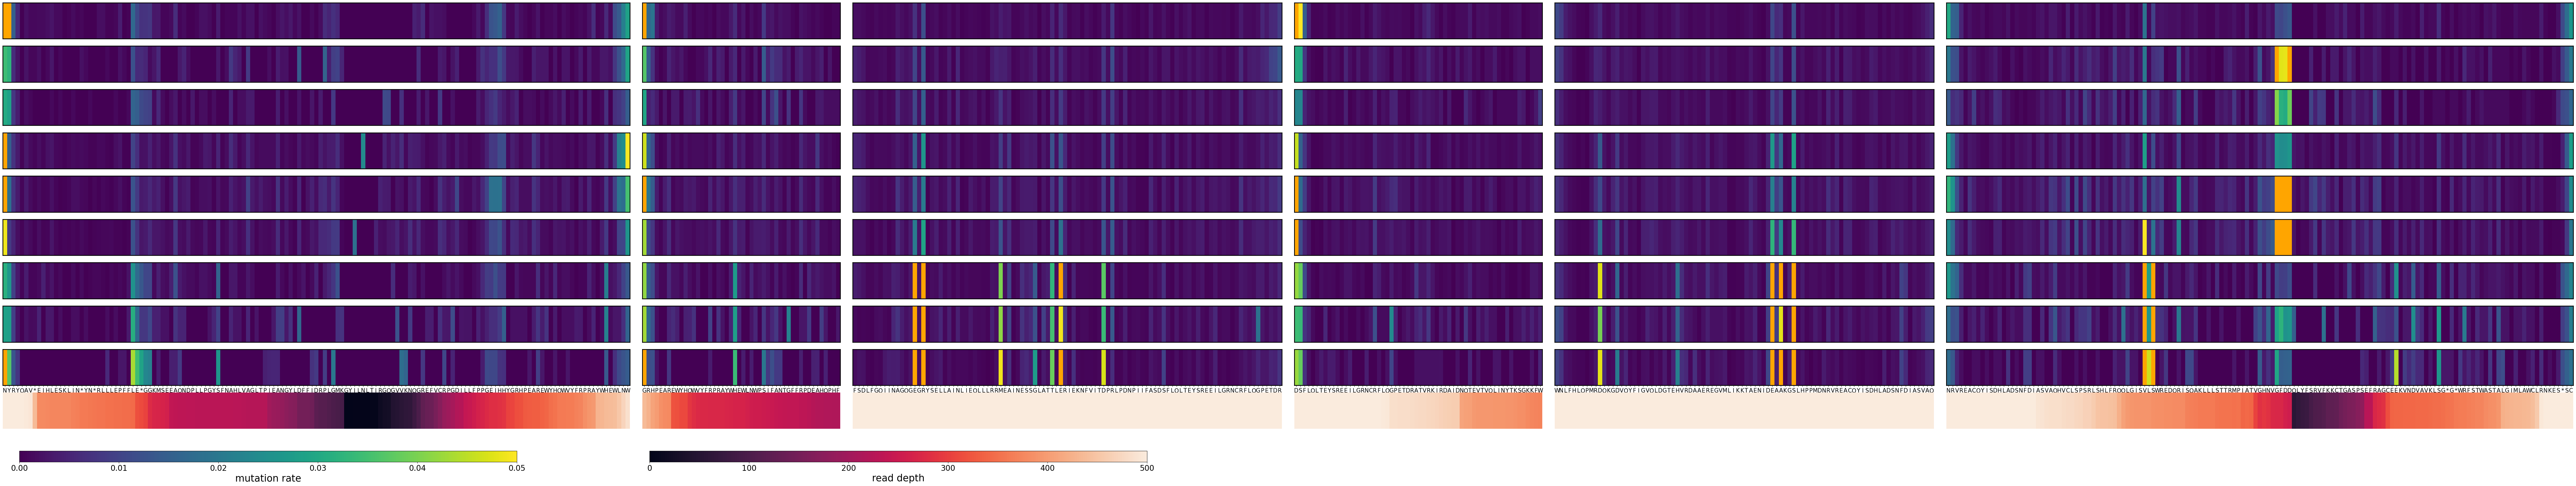

<Figure size 640x480 with 0 Axes>

In [27]:
FigFolder = os.path.join(base_dir, "output/PACE/final_plots")
compare_mut_enrichement_for_all(all_reads, ref_gene, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, samples = samples, plt_titles =plt_titles,   Sections = Sections,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.05, show_cbar_for_each = False, show_plttitles = False, bias_per_pos= None, include_BCs=False, plt_section_ratios=[450, 142, 308, 178,272, 450])

In [ ]:
FigFolder = None#os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2")
compare_mut_enrichement_for_all(all_reads, ref_gene, data_type = "AA", combine_mut_rates=True, FigFolder=FigFolder, samples = samples, plt_titles =plt_titles,   Sections = Sections,Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.05, show_cbar_for_each = False, show_plttitles = False, bias_per_pos= None, include_BCs=False)

In [35]:
## filter pos at the beginning, since these have a high error rate, i.e. mutation rate is not reliable
for sections, values in high_mut_pos_dict.items(): 
    ### exclude every value below 3: 
    high_mut_pos_dict[sections] = [value for value in values if value >=3]

/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes

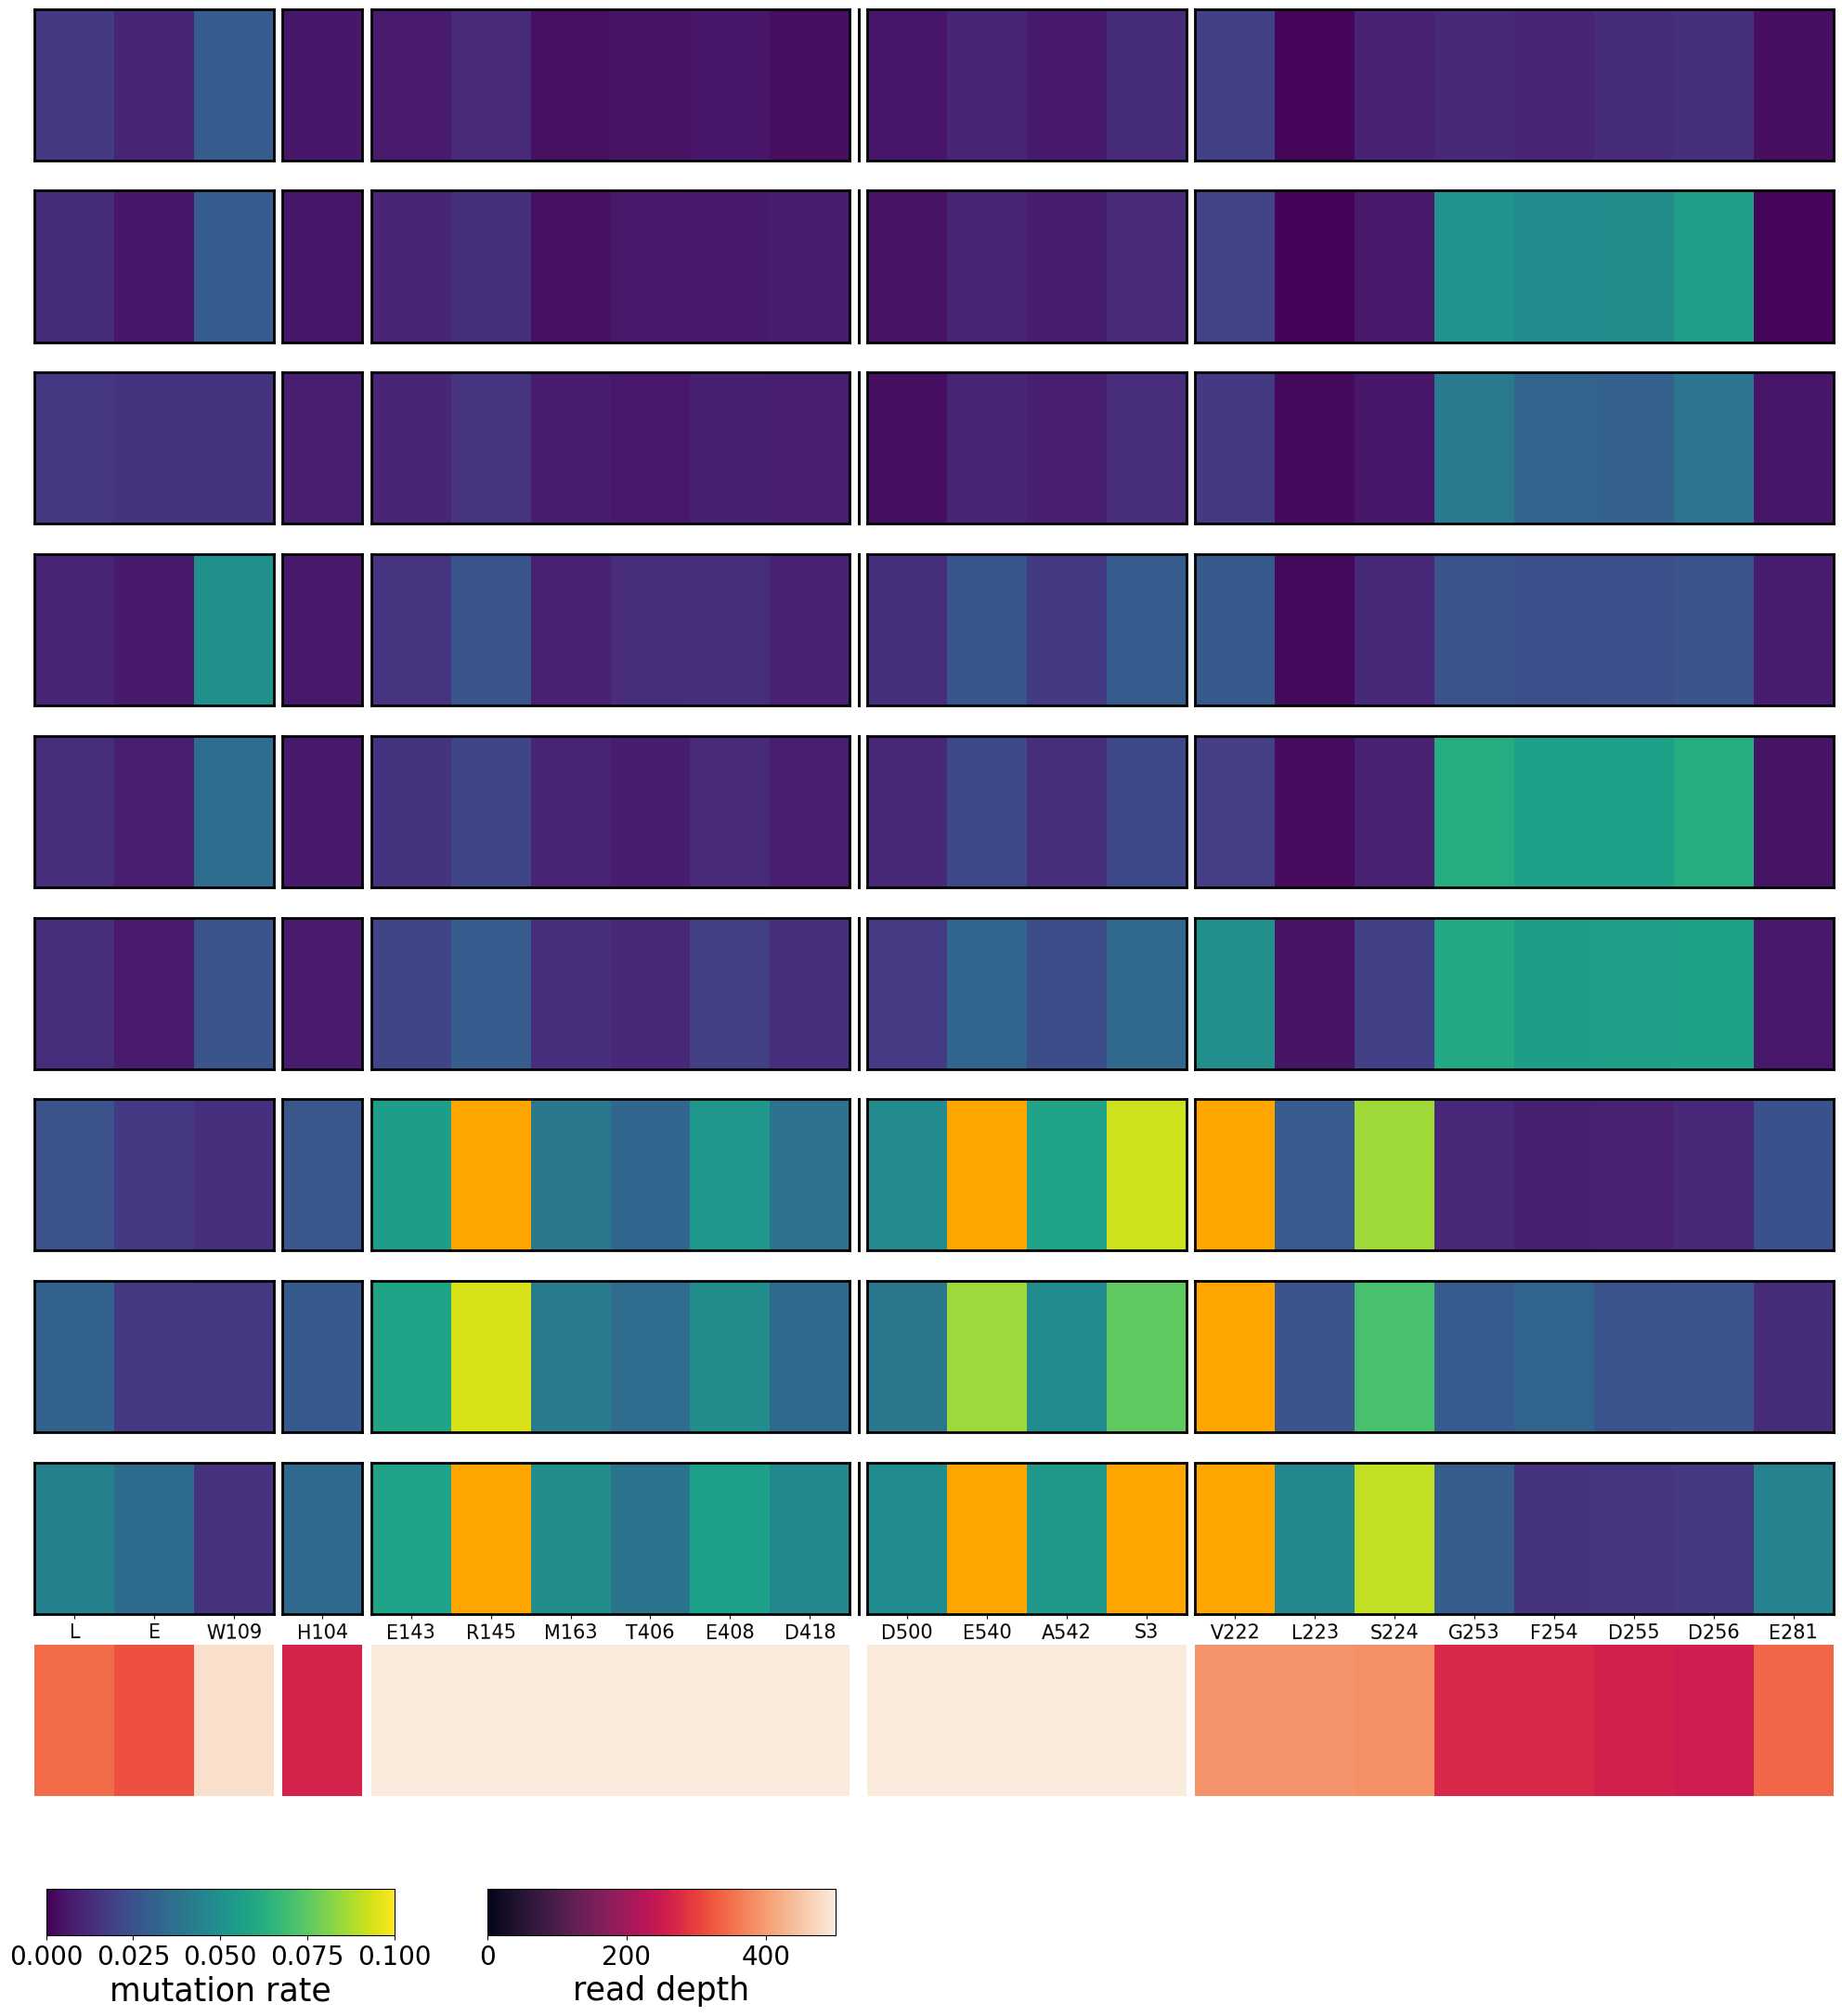

<Figure size 640x480 with 0 Axes>

In [45]:
FigFolder = None #os.path.join(base_dir, "output/PACE/final_plots")
most_enriched_regions = compare_mut_enrichement_for_all(all_reads, ref_gene,  data_type = "AA", combine_mut_rates=True, Sections = Sections, FigFolder=FigFolder, samples = samples,  plt_titles =plt_titles, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.1, show_cbar_for_each = False, show_plttitles = False,show_only_pos= high_mut_pos_dict, bias_per_pos= None, AApos_xlabelticks=R5_Pool_AA_annot, return_df = True,  plot_coverage=True, fig_size=(25,25))

In [50]:
import functions_
reload(functions_)
from functions_ import *
import plotting
reload(plotting)
from plotting import *

/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/student/miniforge3/envs/DMS-analysis/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes

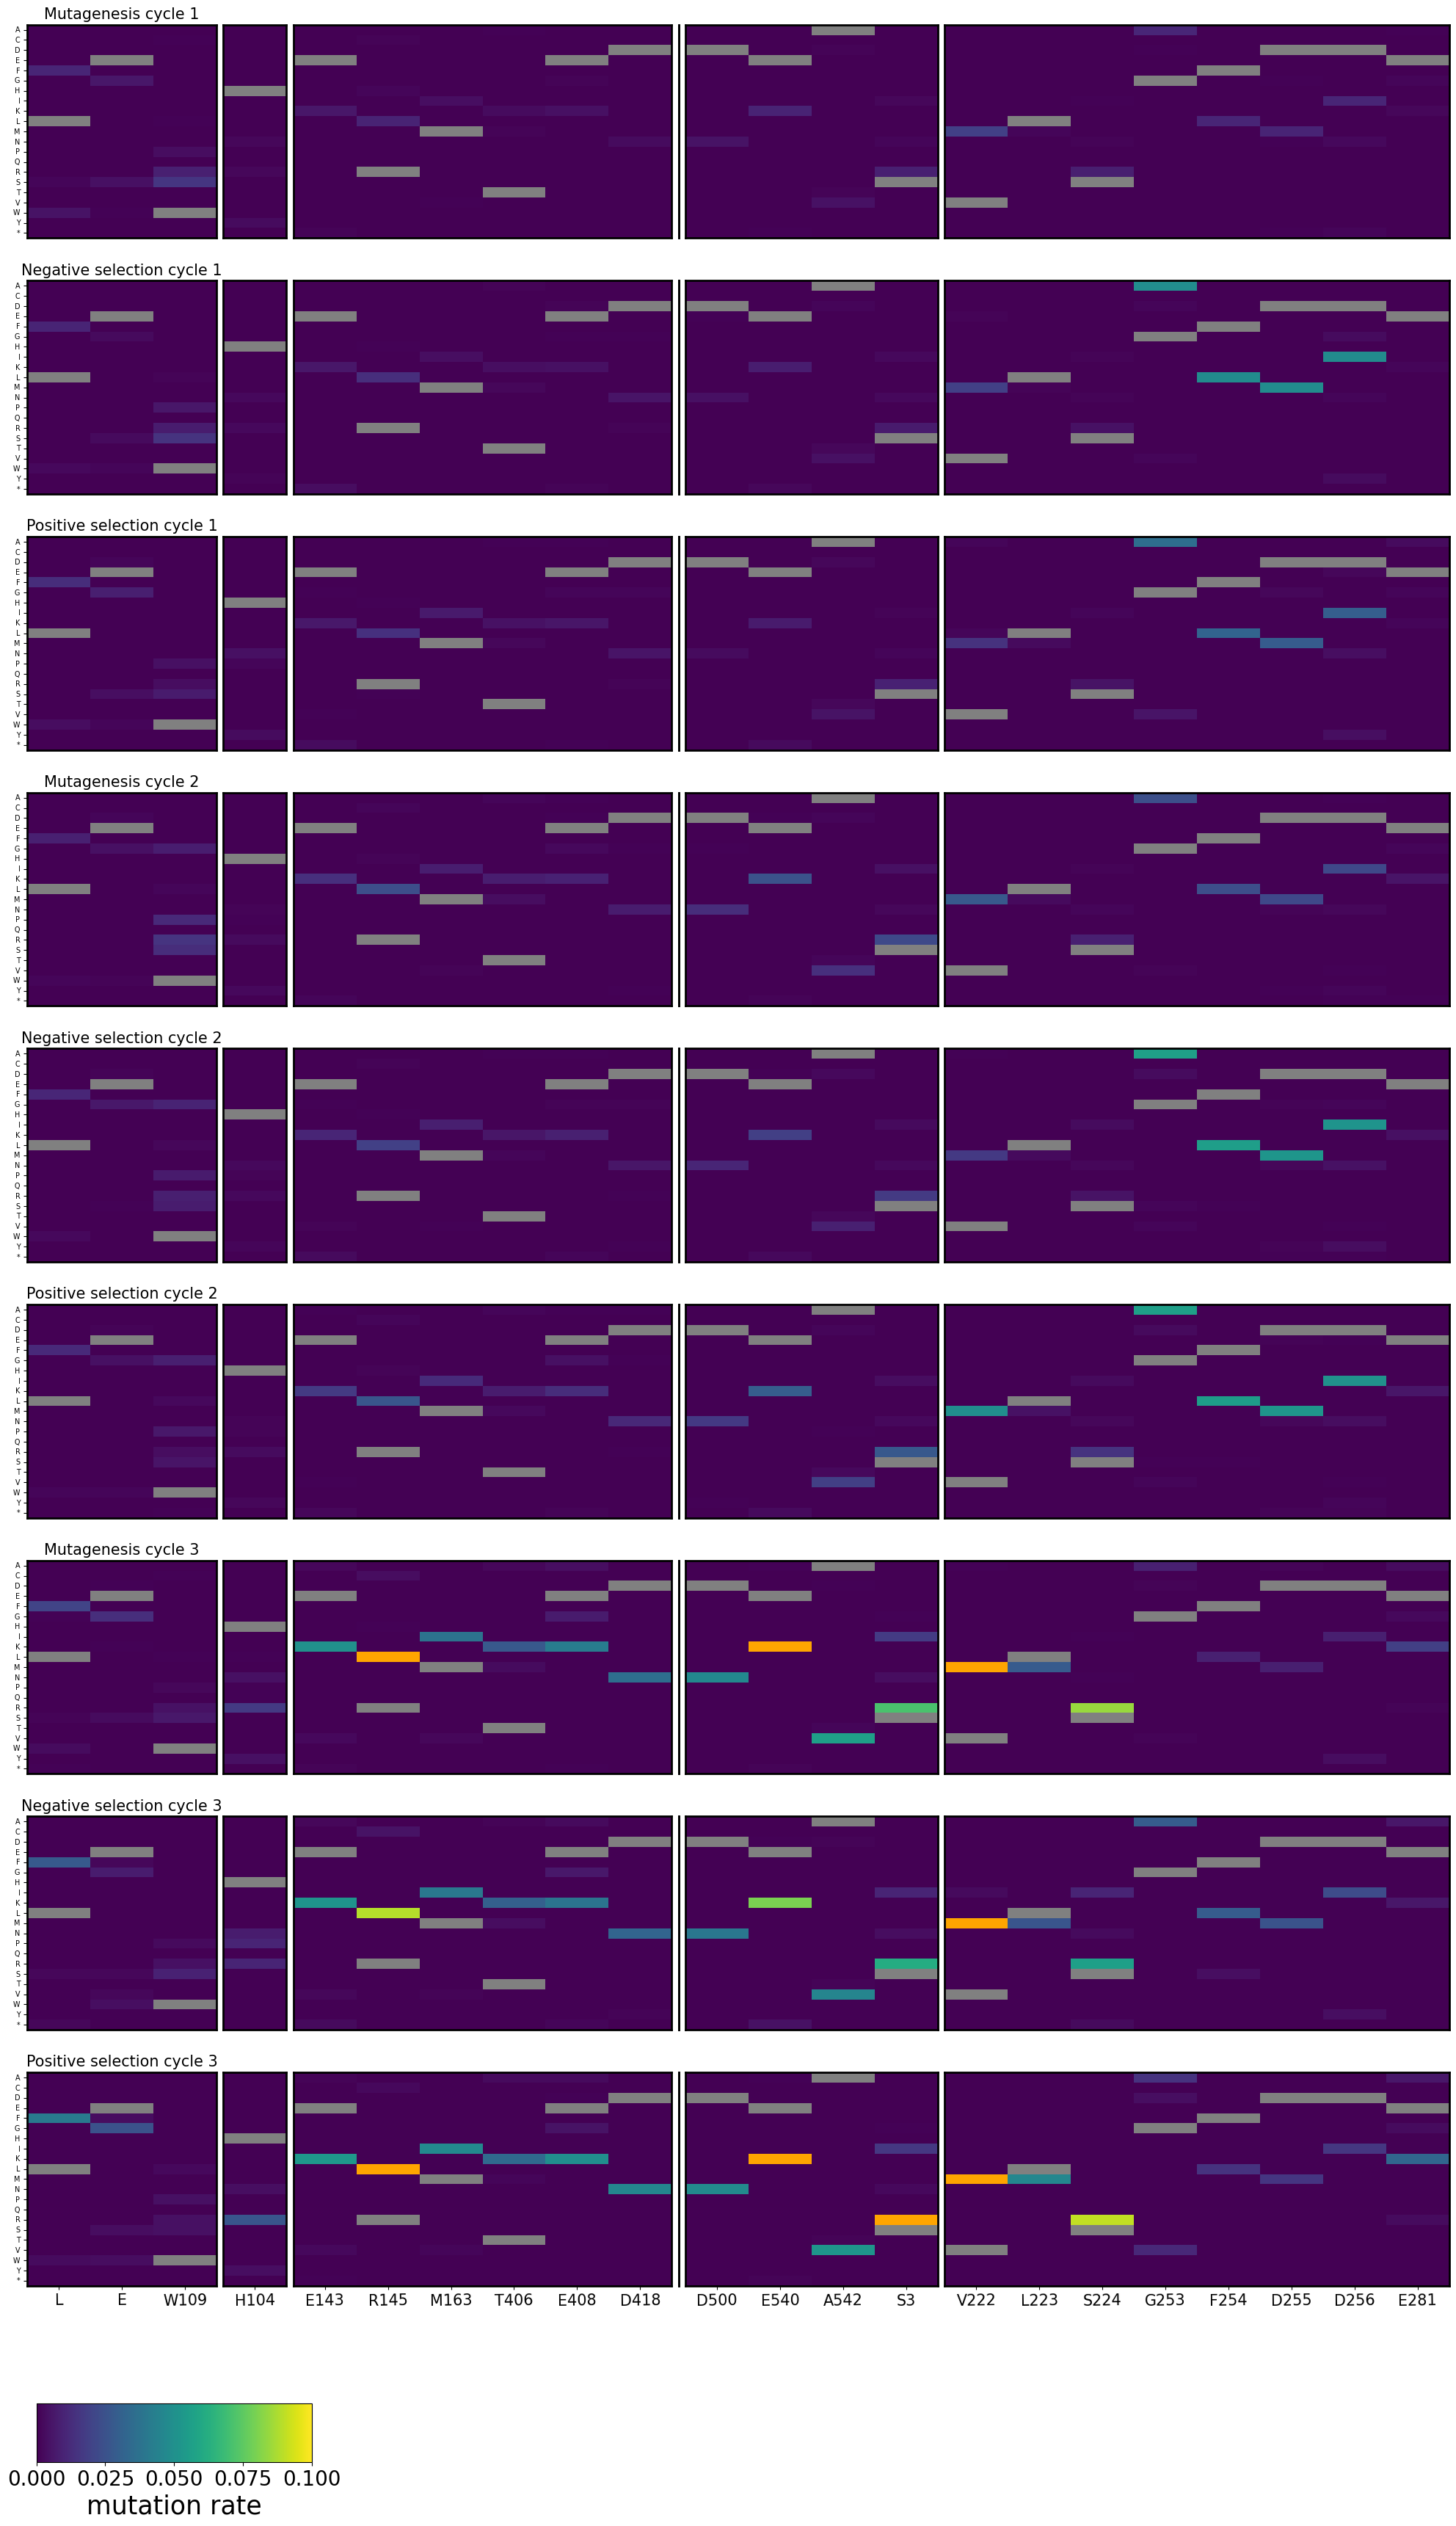

<Figure size 640x480 with 0 Axes>

In [51]:
most_enriched_regions = compare_mut_enrichement_for_all(all_reads, ref_gene,  data_type = "AA", combine_mut_rates=False, Sections = Sections, FigFolder=FigFolder, samples = samples,  plt_titles =plt_titles, Primer_out_of_triplets=Primer_out_of_triplets, Barcodes=Barcodes, Primer_seq= Primer_seq, vmax =0.1, show_cbar_for_each = False, show_plttitles = True,show_only_pos= high_mut_pos_dict, bias_per_pos= None, AApos_xlabelticks=R5_Pool_AA_annot, return_df = True, fig_size = (25, 40), plot_coverage=False)

In [ ]:
exclude_pos = ["D501",  "D505", "A542",  "A543", "S4", "L171",  "H172", "N194"]
not_exclude = [pos for pos in most_enriched_regions.columns if pos not in exclude_pos]
#most_enriched_regions.loc[:,  not_exclude].max(axis = 1)
show_pos = ["R146", "M164", "E409", "E541", "S4"] #"G254", "F255", "D257 #"M164", "E541", "S4",

In [ ]:
#most_enriched_regions = most_enriched_regions.iloc[[0,2,3,5,6,8],:]

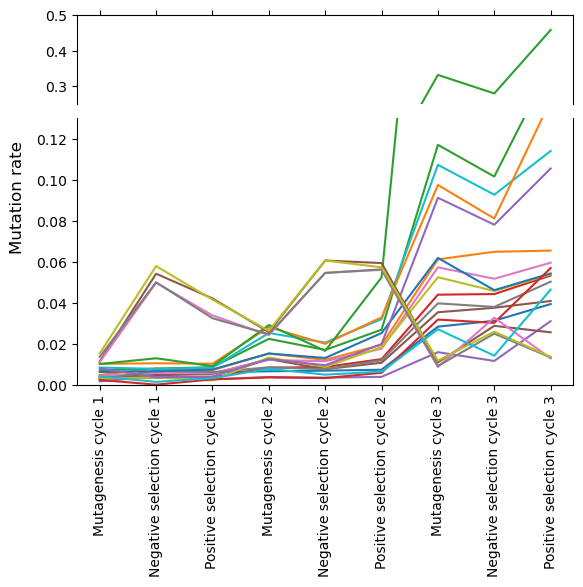

In [208]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [1, 3]})
ax.plot(most_enriched_regions.iloc[:,2:])#(most_enriched_regions.loc[:,  show_pos])
ax2.plot(most_enriched_regions.iloc[:,2:])#(most_enriched_regions.loc[:,  show_pos])
ax.set_ylim(0.25, 0.5)  # most of the data
ax2.set_ylim(0, 0.13)  # outliers only

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top

# Adjust layout to ensure clean spacing
plt.subplots_adjust(hspace=0.08)

# Set up the labels and show the plot
plt.xticks(rotation=90)
f.supylabel("Mutation rate")
plt.show()

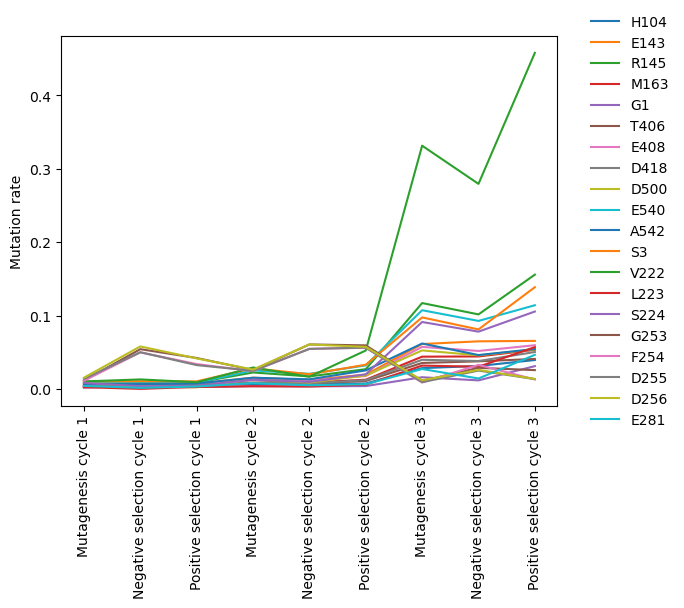

In [210]:
#c= ["lightsteelblue","royalblue",  "mediumblue", "navy", "gold", "sandybrown", "chocolate"]
plt.plot(most_enriched_regions.iloc[:,2:])#(most_enriched_regions.loc[:,  show_pos])
# for idx, color in enumerate(c): 
#     plt.gca().get_lines()[idx].set_color(color)
plt.xticks( rotation = 90)
plt.ylabel("Mutation rate")
#plt.ylim(0,0.15)
plt.legend(labels = most_enriched_regions.columns[2:], frameon = False, loc = "right", bbox_to_anchor=(1.25, 0.5))
#plt.savefig(os.path.join(base_dir, "output/PACE/cycle_mut_enrichment/cycle_mut_enrichment_wC2/mut_enrichment_pattern_line_plot.pdf"))
plt.show()

In [209]:
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
variant = "NegPosSelection"
mut_rates = []
chance_of_muts = []

for Section in Sections:

    tripl_st = Primer_out_of_triplets[Section+"_fwd"]
    tripl_end = Primer_out_of_triplets[Section+"_rev"]
    ref_gene_section = find_reference_seq(ref_gene=ref_gene,Section = Section, Primer_seq=Primer_seq, Primer_out_of_triplets=Primer_out_of_triplets)
    ref_prot_section = translate_dna2aa(ref_gene_section)

    a_seq = all_reads[ f"{variant}_{Bc}_{Section}_R1"]
    b_seq = all_reads[ f"{variant}_{Bc}_{Section}_R2"]

    seq_variants = gather_codon_variants(a_seq=a_seq, b_seq = b_seq, catch_left=Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_rev"]+Primer_seq[Section+"_rev"][:tripl_end]), ref = ref_gene_section, use_forward_read=True, use_rev_read=False)

    seq_variants = pd.DataFrame.from_dict(seq_variants)

    coverage_df = seq_variants.sum()
    seq_variants = seq_variants.loc[:,coverage_df>0]
    
    _ , mut_rates_section= mask_ref_in_variants_df(variant_df =seq_variants, ref_seq= ref_gene_section, data_type="Codons")
    mut_rates.extend(mut_rates_section.sum())
    chance_of_muts.extend(chance_of_mut_pos_dict[Section][:len(mut_rates_section.sum())])

KeyError: 'NegPosSelection_BC4_S1_R1'

In [ ]:
plt.scatter(mut_rates, chance_of_muts, alpha=0.5)
plt.xlim(-0.008, 0.07)
plt.xlabel( "Mutation rate (PosSel Cycle3)" )
plt.ylabel( "Chance of codon mutation")#

In [ ]:

import scipy.stats
scipy.stats.spearmanr(mut_rates, chance_of_muts)

In [ ]:
#figfolder = "output/PACE/cycle_mut_enrichment"
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC2"
CylceB = "NegPosSelection" #"Mutagenesis"
BarcodeB = "BC1"
Sections = ["S1", "S2", "S3", "S4"]
name = "Pos Selection 3 vs Mutagenesis 1"
combine_mut_rates=True
vmax = 1
show_cbar_for_each = False
cbar_label = "log2FC(A/B)"

fig = plt.figure(figsize=(70, 3))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.2], width_ratios=[1, 1, 1, 1])

axes = []
for i in range(2):
    row_axes = []
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

fig.suptitle(name, fontsize = 25, y=1.08)

fig.subplots_adjust(wspace=0.03, hspace=0.5)

for idx, Section in enumerate(Sections): 
    stepA = f"{CycleA}_{BarcodeA}_{Section}"
    stepB = f"{CylceB}_{BarcodeB}_{Section}"

    FC_variants, ref, coverage_A, coverage_B = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA", combine_mut_rates=combine_mut_rates)

    my_cmap = plt.get_cmap('coolwarm').copy()
    my_cmap.set_over('saddlebrown')
    my_cmap.set_under('navy')


    #plot_mutation_enrichment(FC_variants,  name = f"{stepA} vs {stepB}", ref_seq=ref, data_type = "AA", fig_folder= None, cmap = "coolwarm", cbar_label=f"log2FC({stepA}/{stepB})", vmax = 0.05)  
    sns.heatmap(pd.DataFrame(FC_variants).T ,cmap = my_cmap, xticklabels=ref, yticklabels=not combine_mut_rates, center = 0, ax = axes[0][idx], cbar = show_cbar_for_each, vmax = vmax, vmin = -vmax if vmax else None ,square = not combine_mut_rates)
    axes[0][idx].set_title(Section, fontsize = 20)
    axes[0][idx].set_xticklabels(axes[0][idx].get_xticklabels(), rotation=1, fontsize=10)
    sns.heatmap(pd.DataFrame(coverage_A).T, linecolor="black", xticklabels=False, yticklabels=False, ax = axes[1][idx], cbar = show_cbar_for_each, vmax = 500, vmin = 0)

if not show_cbar_for_each:
    ## add at the bottom of the figure horizontally a cbar for the relative counts
    cbar_ax = fig.add_axes([0.13, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[0][0].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label(cbar_label, fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(axes[0,0].collections[0], cax=cbar_ax)
    # cbar.set_label('relative counts', fontsize = 20)
    # cbar.ax.tick_params(labelsize=15)

    # ## ad cbar also for coverage
    cbar_ax = fig.add_axes([0.24, 0, 0.1, 0.06])
    cbar = fig.colorbar(axes[1][3].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_label('read depth', fontsize = 20)
    cbar.ax.tick_params(labelsize=15)

#plt.savefig(figfolder + f'/{name.replace(" ", "_")}_log2FC.pdf', bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
CycleA = "NegPosSelection"#"Mutagenesis"
BarcodeA = "BC4"
CylceB = "Mutagenesis"
BarcodeB = "BC1"
Section = "S2"

stepA = f"{CycleA}_{BarcodeA}_{Section}"
stepB = f"{CylceB}_{BarcodeB}_{Section}"



FC_variants, ref, _,_ = calculate_log_FC(read_dictionary=all_reads, stepA=stepA, stepB=stepB, Section=Section, BarcodeA=BarcodeA, BarcodeB=BarcodeB, Primer_out_of_triplets=Primer_out_of_triplets,codons=codons,Primer_seq=Primer_seq, Barcodes=Barcodes, ref_gene=ref_gene,data_type="AA",combine_mut_rates=True)

name = "Neg vs Pos Selection cycle 1 "+ Section
plt.figure(figsize=(20,2))
sns.heatmap(pd.DataFrame(FC_variants).T, cmap = "coolwarm", cbar_kws = {"pad": 0.02, "label": "Log2FC(Pos/Neg)" },linecolor="black", xticklabels=ref, yticklabels=False, center = 0)
plt.xticks(rotation = 2,fontsize=6)
plt.title(name)
plt.show()


In [ ]:
# mutagenic spectrum codons
Sections = ["S1", "S2", "S3", "S4"]
Bc = "BC4"
cycle = "NegPosSelection"
use_rev_read = False

combined_ref_sections = []


for idx, Section in enumerate(Sections): 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]

    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum_codons(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left="",catch_right="",use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)
    

    if idx == 0:
        overall_mut_spectrum = pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    else: 
        overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")

    combined_ref_sections.append(ref_seq_Section)

combined_ref_sections = "".join(combined_ref_sections)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100

ref_codons = [combined_ref_sections[i:i+3] for i in range(0, len(combined_ref_sections), 3)]
# np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
# np.fill_diagonal(overall_mut_spectrum.values, np.nan)


In [ ]:
overall_mut_spectrum_perc = overall_mut_spectrum_perc.loc[[codon for codon in codons if codon in ref_codons],:]

In [ ]:
AAs = list(set(genetic_code.values()))
AA_codons = {Aa: [codon for codon, aa in genetic_code.items() if aa == Aa] for Aa in AAs}

AA_cod_mut_spectrum = pd.DataFrame(index=AAs, columns=codons, data = 0.0)

for aa in AAs:
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_cod_mut_spectrum.loc[aa,:] += overall_mut_spectrum_perc.loc[cod,:]

AA_mut_spectrum = pd.DataFrame(index=AAs, columns=AAs, data = 0.0)
for aa in AAs: 
    aa_cod = AA_codons[aa]
    for cod in aa_cod:
        AA_mut_spectrum.loc[:,aa] += AA_cod_mut_spectrum.loc[:,cod]

In [ ]:
sns.clustermap(AA_mut_spectrum)

In [ ]:
sns.clustermap(overall_mut_spectrum_perc, cmap = "viridis", cbar = True, cbar_kws = {"pad": 0.02, "label": "Mutation rate" },linecolor="black", dendrogram_ratio=(.00001, .00001))

In [ ]:
overall_mut_spectrum

In [ ]:
all_reads.keys()

In [ ]:
# mutagenic spectrum
Sections = [ "S2", "S3"]
Bc = "BC1"
cycle = "S2S3alt3cyclesmut"
use_rev_read = True

overall_mut_spectrum =pd.DataFrame(index=["A", "C", "G", "T"], columns=["A", "C", "G", "T"], data = 0)
combined_ref_sections = []


for Section in Sections: 
    tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
    tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
    ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
    n_mut_spectrum, n_mut_spectrum_perc  = mut_spectrum(all_reads[f"{cycle}_{Bc}_{Section}_R1"], all_reads[f"{cycle}_{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]),use_rev_read=use_rev_read,use_forward_read=True, reference_seq=ref_seq_Section)

    print(pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float"))

    overall_mut_spectrum += pd.DataFrame.from_dict(n_mut_spectrum, orient='index', dtype = "float")
    combined_ref_sections.append(ref_seq_Section)

chance_of_mutation_df = overall_mut_spectrum/overall_mut_spectrum.sum(axis = 1)
np.fill_diagonal(overall_mut_spectrum_perc.values, np.nan) # set diagonal (= filled with zeros, since this is no mutation) to NA (for plotting)
np.fill_diagonal(overall_mut_spectrum.values, np.nan)

print(overall_mut_spectrum)
overall_mut_spectrum_perc = overall_mut_spectrum/overall_mut_spectrum.sum().sum()*100



print(overall_mut_spectrum_perc)
print(chance_of_mutation_df)


In [ ]:
## expected mut spectrum
combined_ref_sections = "".join(combined_ref_sections)
mut_spec_expected = {"A": {"A":0, "C":0, "G":0, "T":0}, ## {reference nt: {mutated nt: count}}
                    "C" : {"A":0, "C":0, "G":0, "T":0},
                    "G" : {"A":0, "C":0, "G":0, "T":0},
                    "T" : {"A":0, "C":0, "G":0, "T":0}}
for ref_nt in combined_ref_sections:
    for mut_nt in ["A", "C", "G", "T"]:
        if ref_nt != mut_nt:
        ## calculate mutagenic spectrum for all expected changes per Nt
            mut_spec_expected[ref_nt][mut_nt] += 1

mut_spec_expected = pd.DataFrame.from_dict(mut_spec_expected, orient='index', dtype = "float")
mut_spec_expected_perc = mut_spec_expected/mut_spec_expected.sum().sum()*100

plot_mutation_spectrum(mut_spec_expected_perc, samplename = "Mutagenesis", fig_folder = None, colormap = "viridis")

In [ ]:
plot_mutation_spectrum(overall_mut_spectrum_perc,samplename = "All fwd reads",  fig_folder = "output/PACE/repS2S3/")

In [ ]:
all_reads.keys()

In [ ]:
## Look for coocurrence of mutations in the same read (choose positive selection cylce 3)
## specifically E144K and R146L mutations
## is in Section 2
Section = "S2" 
Bc = "BC6"
read_of_interest = all_reads[f"NegPosS2S3_2_{Bc}_{Section}_R1"] #all_reads[f"S2S3alt3cyclesNegPos_{Bc}_{Section}_R1"]#[f"NegPosSelection_{Bc}_{Section}_R1"] ## fwd read section 2 pos selection cycle 3
region = "ISVLS" 
region = "QGEGR"

## find the positions of the mutations

tripl_st = Primer_out_of_triplets[Section+"_fwd"]
ref_gene_section = find_reference_seq(ref_gene = R5_Pool_seq, Primer_seq = Primer_seq, Section = Section, Primer_out_of_triplets = Primer_out_of_triplets)
ref_protein_section = translate_dna2aa(ref_gene_section)

catch_left = Barcodes[f"{Bc}_fwd"]+Primer_seq[Section + "_fwd"][:tripl_st]
AA_seqs = [translate_dna2aa(dna[dna.index(catch_left)+len(catch_left):]) for dna in read_of_interest if catch_left in dna]

index_of_interest = ref_protein_section.index(region)
sections_of_interest = [AA_seq[index_of_interest:index_of_interest+len(region)] for AA_seq in AA_seqs] 
sections_of_interest = [sec for sec in sections_of_interest if len(sec)==len(region)]## keep only those that have the region of interest

## find occurences of mutations
coocurrence = {}
for sec in sections_of_interest:
    if sec[2:] not in coocurrence:
        coocurrence[sec[2:]] = 1
    else: 
        coocurrence[sec[2:]] += 1

## order coocurrence after value size
coocurrence = dict(sorted(coocurrence.items(), key=lambda item: item[1], reverse=True))
## filter for coocurrence > 1 (exclude seq errors)
coocurrence = {key: value for key, value in coocurrence.items() if value > 5}

In [ ]:
coocurrence

In [ ]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey
plt.title("Co-occurrence E144K, R146L mutations")#V223M, L224M, S225R mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
#plt.savefig("output/PACE/mutation_cooccurrence/Cooccurence_E144K_R146L_repSeqS2.pdf")

In [ ]:
colors = ["grey" if key == region[2:] else "tab:blue" for key in coocurrence.keys()]
coocurrence_perc = {key: val/sum(coocurrence.values())*100 for key, val in coocurrence.items()}
plt.bar(coocurrence_perc.keys(), coocurrence_perc.values(), color = colors, )
## set color of reference as grey

plt.title("Co-occurrence E144K, R146L mutations")
plt.ylabel("Relative Frequency (%)")
plt.xlabel("Sequence")
## add legend
grey_patch = mpatches.Patch(color='grey', label='Reference')
blue_patch = mpatches.Patch(color='tab:blue', label='Mutated')
plt.legend(handles=[grey_patch, blue_patch], frameon = False)
plt.savefig("output/PACE/mutation_cooccurrence/Cooocurrence_E144K_R146L.pdf")